## Tutorial of WEST 
The tutorial provides a brief instruction of how to implement the proposed method WEST (Weighted Ensemble method for Spatial Transcriptomics). The data used in the tutorial is the Visium data of a human brain cortex tissue. The detailed introduction of the data can be found in the paper. WEST is designed to ensemble the embeddings from multiple deep learning-based methods to achieve a better performance on the spatial domain identification. 

### 1. Import packages 
The packages imported here is the minimum requirement to run the WEST pipeline. The version of all packages is listed in the requirements.txt. Since the deep learning-based methods have much more complicated requirements to the environment, it is almost impossible to build an environment which is applicable for all of them. To simplify the tutorial, we provide the embeddings from two deep learning-based methods, SpaGCN and SpaceFlow, which is the only required data in the WEST pipelines. The pipeline can be easily extended to other deep learning-based methods.

In [1]:
# Import pacakges
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import umap
import scanpy as sc
import pickle

from sklearn.metrics.cluster import adjusted_rand_score

from ../WEST import WEST
import ../WEST_plt

/home/stat/anaconda3/envs/WEST_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load data 
The required input of the pipeline is the gene expression count matrix X and spatial coordinate of each spot S. The two data matrics are saved in an anndata object, which is used in the subsequent analyses.

In [2]:
#### Gene expression
X = pd.read_csv('../data/X.csv')
#### Spatial location
S = pd.read_csv('../data/S.csv')

#### Construct adata object
adata = anndata.AnnData(pd.DataFrame(X.to_numpy()))

adata.obs['loc_x'] =  S['x'].to_numpy()
adata.obs['loc_y'] =  S['y'].to_numpy()

#### Real cluster
adata.obs["true cluster"] =  S['cluster'].to_numpy()
adata.obs["true cluster"] = adata.obs["true cluster"].astype("category")

/home/stat/anaconda3/envs/WEST_new/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/stat/anaconda3/envs/WEST_new/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### 3. Load embedding & clustering result 
The embeddings of SpaGCN and SpaceFlow are loaded. They are the only required data for the WEST pipeline. To compare the spatial domain identification performance, we also load the spatial domain identification result of them, but they are not required for the WEST pipeline.

In [3]:
# Load embedding data
adata.obsm['SpaGCN'] = np.genfromtxt('../embedding/SpaGCN_embedding.csv', delimiter=',')
adata.obsm['SpaceFlow'] = np.genfromtxt('../embedding/SpaceFlow_embedding.csv', delimiter=',')

# Load clustering result
adata.obs['SpaGCN'] = np.genfromtxt('../embedding/SpaGCN_cluster.csv', delimiter=',', dtype=str)
adata.obs['SpaceFlow'] = np.genfromtxt('../embedding/SpaceFlow_cluster.csv', delimiter=',', dtype=str)

### 4. Run WEST 
This is the core step of the WEST pipeline. The description of the key parameters is listed as follow:  
-adata: an anndata.AnnData type object.  
-reps: the embeddings to integrate, e.g., ['SpaGCN', 'SpaceFlow'].  
-n_neighbors: number of neighbors, defalut: 20.  
-npcs: number of PCs to use, e.g., [20, 30]. If None, then use the original embedding, defalut: None.  
-seed: random seed, default: 1234.  
-distances: distance matrix. If None, then calculate the distance matrix, defalut: None.  

In [4]:
# Construct WEST object
west_obj = WEST(adata=adata, reps=['SpaGCN', 'SpaceFlow'], n_neighbors=10, npcs=None, seed=1234, distances=None)
# Compute the similarity matrix
west_obj.compute_west()
adata_west = west_obj.adata

Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
time: 1.67 seconds
Selecting top K neighbors


### 5. Clustering  
Based on the calculated similarity matrix, we use Leiden to identify the spatial domain. To compare the performance of spatial domain detection, we calculate the adjusted rand index for WEST and the two ensembled two methods.

In [5]:
# Clustering using Leiden
sc.tl.leiden(adata_west, key_added="WEST_leiden", obsp="WEST", resolution=0.4)
# Compare clustering result
print("ARI for WEST: ", adjusted_rand_score(adata_west.obs["WEST_leiden"], adata_west.obs["true cluster"]))
print("ARI for SpaGCN: ", adjusted_rand_score(adata_west.obs["SpaGCN"], adata_west.obs["true cluster"]))
print("ARI for SpaceFlow: ", adjusted_rand_score(adata_west.obs["SpaceFlow"], adata_west.obs["true cluster"]))

/tmp/ipykernel_10655/2440797097.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_west, key_added="WEST_leiden", obsp="WEST", resolution=0.4)


ARI for WEST:  0.5322530452942107
ARI for SpaGCN:  0.4486460327603472
ARI for SpaceFlow:  0.42742318469084856


### 6. Generate new embedding 
This step is to generate the embedding based on the calculated similarity matrix.

In [9]:
adata_west.obsm['WEST'] = west_obj.get_embedding(dim=50)
adata_west.obsm['WEST']

array([[ 1.66112580e-04, -1.32608534e-04,  2.05129249e-06, ...,
         1.03302440e-04, -7.09466662e-05,  1.91788557e-04],
       [ 3.37934432e-05, -2.65599383e-05, -4.82109113e-05, ...,
        -2.50736329e-04,  2.30024184e-04, -4.61244215e-05],
       [ 1.13948146e-04, -1.87798451e-04,  2.94634270e-04, ...,
        -1.25836616e-04, -2.38314828e-04, -2.04553379e-06],
       ...,
       [ 8.25457213e-05, -7.09805492e-05,  2.23862476e-04, ...,
         3.57820070e-05, -4.05070816e-04, -1.27956006e-04],
       [-2.05550178e-04,  1.26139261e-04,  3.09696388e-04, ...,
         2.03938155e-04, -8.26230709e-06,  1.08143798e-04],
       [-2.89629133e-05, -5.47412831e-05, -2.94677127e-05, ...,
        -7.79010158e-05,  1.22572335e-04,  6.71494700e-05]])

### 7. Visualization
We provide two ways to visualize the result. One is to use the scatter plot to visualize the spatial domain detected by each method. It can be used to evaluate how consistent the detected domain is with the manually annotated spatial domain. The other is to use the UMAP plot to see the pattern on the embedding space. The color represents the manually annotated spatial domain. It can be used to find some hidden structures of the tissue and provide more insights.

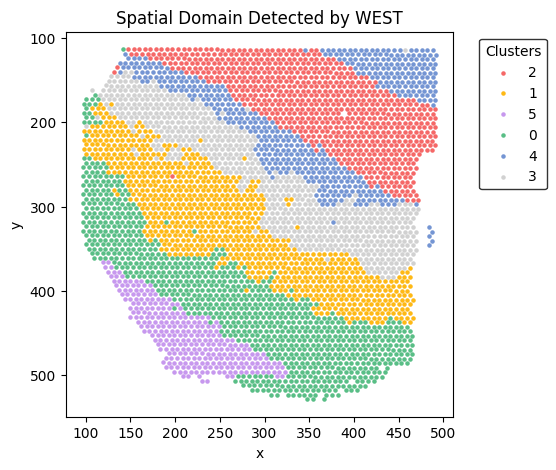

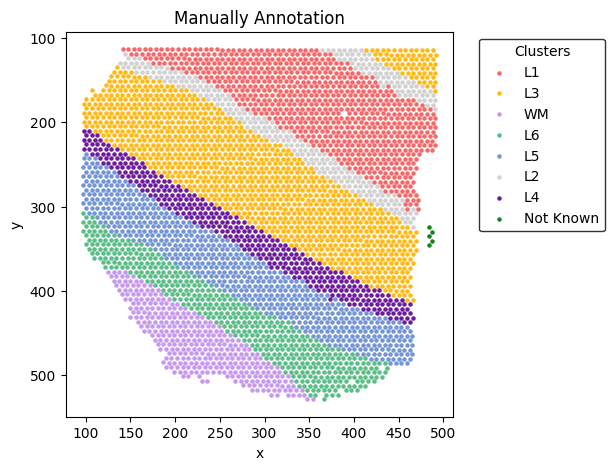

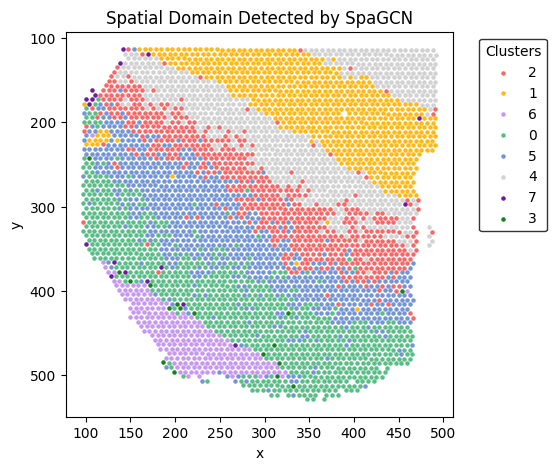

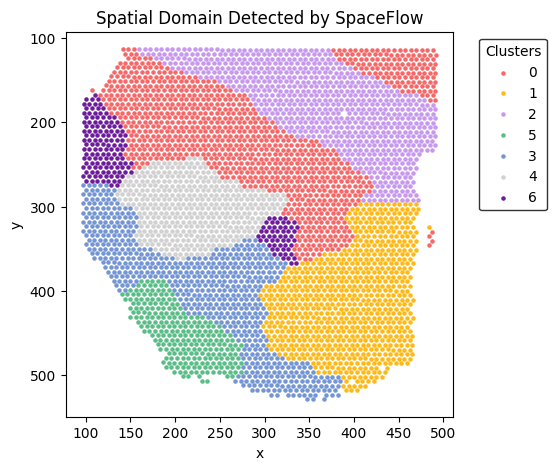

In [7]:
# Visualization using scatter plot
WEST_plt.WEST_scatter(adata=adata_west, reps='WEST_leiden', title='Spatial Domain Detected by WEST', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)
WEST_plt.WEST_scatter(adata=adata_west, reps='true cluster', title='Manually Annotation', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)
WEST_plt.WEST_scatter(adata=adata_west, reps='SpaGCN', title='Spatial Domain Detected by SpaGCN', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)
WEST_plt.WEST_scatter(adata=adata_west, reps='SpaceFlow', title='Spatial Domain Detected by SpaceFlow', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)

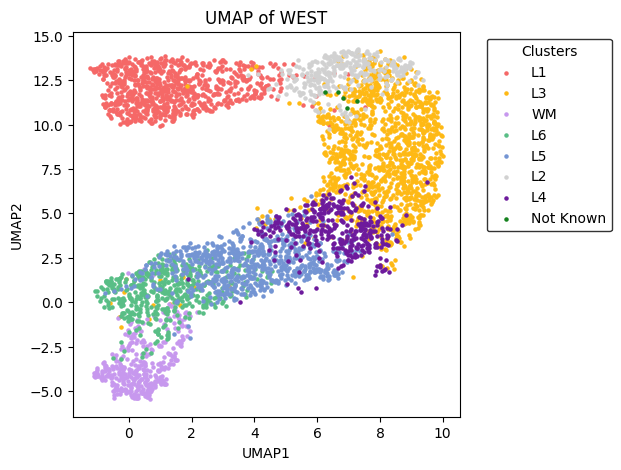

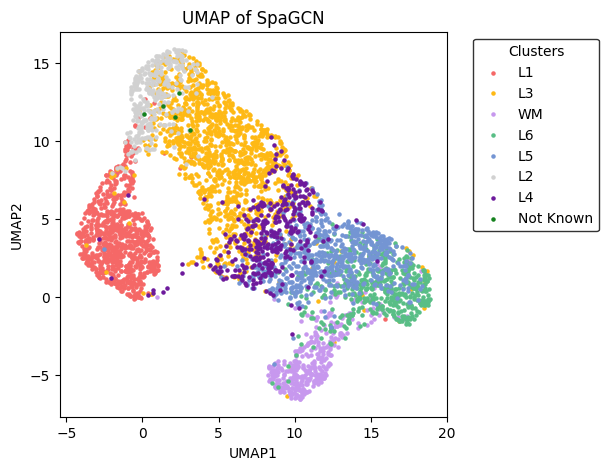

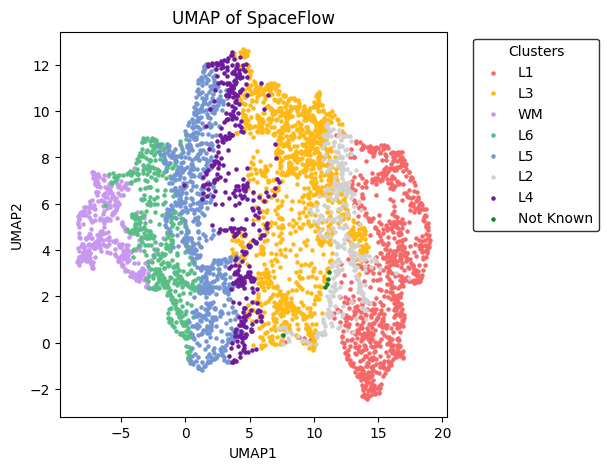

In [8]:
# Visualization using UMAP
WEST_plt.WEST_umap(adata=adata_west, reps='WEST', title='UMAP of WEST', cmap=None, s=5, width=5, height=5, save_path=None)
WEST_plt.WEST_umap(adata=adata_west, reps='SpaGCN', title='UMAP of SpaGCN', cmap=None, s=5, width=5, height=5, save_path=None)
WEST_plt.WEST_umap(adata=adata_west, reps='SpaceFlow', title='UMAP of SpaceFlow', cmap=None, s=5, width=5, height=5, save_path=None)